<a href="https://colab.research.google.com/github/ashley-ferreira/PHYS449_FinalProject/blob/main/notebooks/KerasC1_our_data_40x_trial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 4.7 MB/s 
     |████████████████████████████████| 4.5 MB 69.8 MB/s 
     |████████████████████████████████| 885 kB 79.7 MB/s 
     |████████████████████████████████| 48 kB 3.4 MB/s 
     |████████████████████████████████| 4.0 MB 76.2 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284593 sha256=f5021a3a92bfb27780429a1cafae24784c33541158bfe64a058879d903866f3f
  Stored in directory: /root/.cache/pip/wheels/f2/b6/1f/222aea123a5de8a34c3dd95bb73dca35e342ef3901328e9db0
Successfully built astroNN


In [2]:
#from astroNN.datasets import galaxy10
#from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
#Import google drive (need to put data folder as shortcut in your local drive My Drive):
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Full data**

In [4]:
#LOAD THE DATA FROM TXT FILE INTO A BATCH:
def data_batch(datafile_index, num_images, data_file='MyDrive/data_g_band_v2.txt', plotting=False):
    '''
    Description:
        Access datafile.txt, each row is flattened 110x110 image + 1 label string (E, Sp, S0, Irr+Misc).
        Returns an augmented batch of num_images X 40.
        The labels are converted to 1D vectors (ex: Sp = [0,0,1,0])
        Need to give a datafile_index that tells which rows to pick.
    Inputs:
        datafile_index: index of row in datafile to load. loads rows datafile_index to datafile_index+num_images.
        num_images: number of different images to load per batch, total batch size 
        is 40 X num_images. (default: 10 (for 40X10 = 400 batch size like in paper)
        data_file: datafile full path, need to add shortcut to local Drive. (default: '/content/drive/MyDrive/data/data_g_band.txt')
    Outputs:
        tensor_input_batch_aug: dimensions: (100, 100, num_images X 40).
        tensor_label_batch_aug: dimensions: (num_images X 40, 4)
    '''

    #Take batch of num_images rows from datafile:
    with open(data_file, 'r') as f:
        rows = f.readlines()[datafile_index:(datafile_index+num_images)]

    #for batch size of 400 (augmented), need 10 images
    data_batch = np.zeros((num_images,12101), dtype=np.dtype('U10'))
    count = 0
    for row in rows:
        data_batch[count,:] = row.split()
        count += 1

    #separate label and input:
    input_batch_flat = np.array(data_batch[:,:12100], dtype=float)#, dtype=int)
    label_batch = np.array(data_batch[:,-1])

    #convert input batch back to a 2D array:
    input_batch = np.zeros((110,110,np.shape(input_batch_flat)[0]))#, dtype=int)
    for ii in range(np.shape(input_batch_flat)[0]):
        input_batch[:,:,ii] = np.reshape(input_batch_flat[ii,:], (110,110))


    #convert label batch into into 1D vector: 
    #E=0, S0=1, Sp=2, Irr+Misc=3
    #ex: label = [0,0,1,0] ==> Sp galagy
    arr_label_batch = np.zeros((np.shape(label_batch)[0],4), dtype=int)
    arr_label_batch[:,0] = np.array([label_batch == 'E'], dtype=int)
    arr_label_batch[:,1] = np.array([label_batch == 'Sp'], dtype=int)
    arr_label_batch[:,2] = np.array([label_batch == 'S0'], dtype=int)
    arr_label_batch[:,3] = np.array([label_batch == 'Irr+Misc'], dtype=int)

    if plotting == True:
      #test with image plotted
      plt.imshow(input_batch[:,:,0])
      plt.show()

    #NOW AUGMENT THE BATCH (40X more):
    input_batch_aug = np.empty((100,100,np.shape(input_batch)[2]*40), dtype=int)
    arr_label_batch_aug = np.empty((np.shape(arr_label_batch)[0]*40, 4), dtype=int)

    count = 0
    for ll in range(np.shape(input_batch)[2]):
        #Crop 5X more image (100X100 pixels)
        C1 = input_batch[:100,:100,ll]
        C2 = input_batch[10:,:100,ll]
        C3 = input_batch[:100,10:,ll]
        C4 = input_batch[10:,10:,ll]
        C5 = input_batch[5:105,5:105,ll]

        C = [C1, C2, C3, C4, C5]

        for kk in range(5):
            #Rotate 4X more image (by 90 deg)
            for jj in range(4):
                C_R = np.rot90(C[kk], k=jj)
                input_batch_aug[:,:,count] = C_R
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1
                
                input_batch_aug[:,:,count] = np.swapaxes(C_R,0,1)
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1


    #PUT THE DATA AS A PYTORCH TENSOR:
    #tensor_input_batch_aug = torch.Tensor(input_batch_aug)
    #tensor_label_batch_aug = torch.Tensor(arr_label_batch_aug)
    
    return input_batch_aug, arr_label_batch_aug

# **Get data for a select index**

In [5]:
input_batch_aug, arr_label_batch_aug = data_batch(datafile_index=0, num_images=7500,  data_file='/content/drive/MyDrive/data_g_band_v2.txt', plotting=False)
print(input_batch_aug.shape)
len_input = len(input_batch_aug.T)
#input_batch_aug.reshape((1, 100, 100, 9000))
#print(input_batch_aug.shape)
#print(arr_label_batch_aug.shape)

(100, 100, 300000)


In [6]:
#print(input_batch_aug.shape)
input_batch_aug_final = input_batch_aug.reshape(1, 100, 100, len_input)
print(input_batch_aug_final.shape)
#print(arr_label_batch_aug.shape)

(1, 100, 100, 300000)


# **Data split**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(input_batch_aug_final.T, arr_label_batch_aug, test_size = 0.15)
print(X_train.shape)
print(y_train.shape)

(255000, 100, 100, 1)
(255000, 4)


In [8]:
model = Sequential()
model.add(Conv2D(filters=32, input_shape=(100,100,1), activation='relu', kernel_size=(5,5)))
model.add(Conv2D(filters=64, input_shape=(100,100,1), activation='relu', kernel_size=(5,5)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax')) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 135424)            0         
                                                                 
 dropout (Dropout)           (None, 135424)            0         
                                                                 
 dense (Dense)               (None, 256)               34668800  
                                                        

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=12, validation_split=0.15)

Epoch 1/12
6774/6774 [==============================] - 84s 10ms/step - loss: 0.8230 - accuracy: 0.6901 - val_loss: 0.5736 - val_accuracy: 0.7677
Epoch 2/12
6774/6774 [==============================] - 60s 9ms/step - loss: 0.5647 - accuracy: 0.7672 - val_loss: 0.5135 - val_accuracy: 0.7896
Epoch 3/12
6774/6774 [==============================] - 60s 9ms/step - loss: 0.5038 - accuracy: 0.7910 - val_loss: 0.5273 - val_accuracy: 0.7803
Epoch 4/12
6774/6774 [==============================] - 60s 9ms/step - loss: 0.4343 - accuracy: 0.8192 - val_loss: 0.5197 - val_accuracy: 0.7858
Epoch 5/12
6774/6774 [==============================] - 60s 9ms/step - loss: 0.3538 - accuracy: 0.8557 - val_loss: 0.5730 - val_accuracy: 0.7853
Epoch 6/12
6774/6774 [==============================] - 60s 9ms/step - loss: 0.2823 - accuracy: 0.8868 - val_loss: 0.5684 - val_accuracy: 0.7809
Epoch 7/12
6774/6774 [==============================] - 60s 9ms/step - loss: 0.2249 - accuracy: 0.9115 - val_loss: 0.8188 - val_a

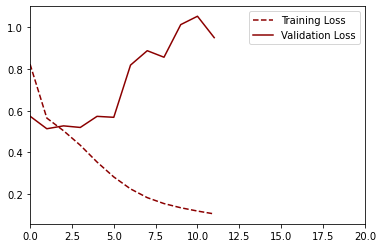

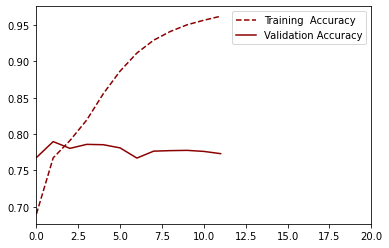

In [12]:
plt.plot(model.history.history['loss'], '--', color='darkred', label='Training Loss')
plt.plot(model.history.history['val_loss'], color='darkred', label='Validation Loss')
plt.legend()
plt.xlim([0, 20])
plt.show()
plt.plot(model.history.history['accuracy'], '--', color='darkred', label='Training  Accuracy')
plt.plot(model.history.history['val_accuracy'], color='darkred', label='Validation Accuracy')
plt.legend()
plt.xlim([0, 20])
plt.show()

1407/1407 [==============================] - 4s 3ms/step


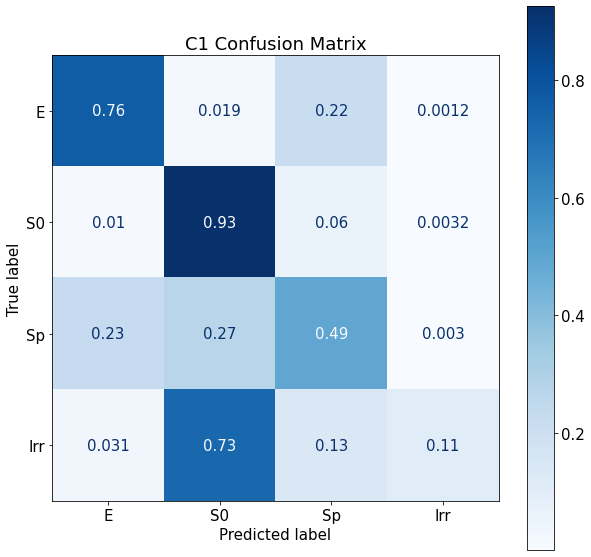

1407/1407 [==============================] - 6s 4ms/step - loss: 0.9400 - accuracy: 0.7745
C1 --> test loss, test acc: [0.9400495886802673, 0.7744666934013367]


In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from pylab import rcParams
rcParams['figure.figsize'] = 10,10
rcParams.update({'font.size': 15})

predictions = model.predict(X_test)
predictions = (predictions > 0.5) 
labels = ['E', 'S0', 'Sp', 'Irr']

cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('C1 Confusion Matrix')
#plt.facecolor("white")
plt.show()

results = model.evaluate(X_test, y_test)
print("C1 --> test loss, test acc:", results)